In [4]:

!pip install bangla-stemmer
!pip install bnltk
!pip install bnlp_toolkit
!pip install tweet-preprocessor
!pip install wordcloud
!pip install https://github.com/JonathanRaiman/glove/archive/master.zip
from bangla_stemmer.stemmer import stemmer
from bnltk.stemmer import BanglaStemmer
from bnltk.tokenize import Tokenizers
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

#!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer


from wordcloud import WordCloud


import preprocessor as p
import keras
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Conv1D,GRU,Concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from bnltk.tokenize import Tokenizers
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder
import gensim
from gensim.test.utils import datapath
from keras.callbacks import EarlyStopping, ModelCheckpoint

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 175 kB 33.5 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 49.5 MB/s eta 0:00:01
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=795a9b2789ea18f8db01ada894786dd23b95e9e6cce64a69b923bdcdcb9c6245
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.1.9
    Uninstalling wcwidth-0.1.9:
      Successfully uninstalled wcwidth-0.1.9
  Attempting uninstall: emoji
    Found existing installation: emoji 0.6.0
    Uninstalling emoji-0.6.0:
      Successfully uninstalled emoji-0.6.0
You

In [5]:
MAX_NUM_WORDS =26000
MAX_SEQ_LENGTH = 140
EMBEDDING_DIM = 300
newdf = []
def clean_tweets(tweets,stem=True, stopword=True):
    stopwordsBN = set(line.strip() for line in open('../input/bn-stopwords/stopwords.txt'))
    stmr = stemmer.BanglaStemmer()
    bn_stemmer = BanglaStemmer()
    cleaned_tweets = []
    a = ""
    tweet = tweets
    word_tokens = nltk.word_tokenize(tweet)
    for w in range(len(word_tokens)):
        a = word_tokens[w]            
        a = "".join(i for i in a if  2432 <= ord(i) <= 2533 or ord(i)== 32)
        tweet = re.sub(' +', ' ', a)
        word_tokens[w] = tweet
    filtered_sentence = None
    if stem==True and stopwords==True:
        filtered_sentence = [bn_stemmer.stem(w) for w in word_tokens if not w in stopwordsBN]
    elif stem==True and stopword==False:
        filtered_sentence = [bn_stemmer.stem(w) for w in word_tokens]
    elif stem == False and stopword==True:
        filtered_sentence = [w for w in word_tokens if not w in stopwordsBN]
    else:
        filtered_sentence = [w for w in word_tokens]
    tweet = ' '.join(filtered_sentence)        
    tweet = str(tweet)
    word_tokens = nltk.word_tokenize(tweet)
    newdf.append(word_tokens)
    return tweet


def preprocess(corpus, stem = True, stopword=True):
    newdf = []
    ls = []
    idd=[]
    siz = []
    dicti = {}
    words=[]

    for i in corpus:
        j = clean_tweets(i,stem,stopword)
        ls.append(j)
    return ls


def convertToTensor(texts):
    print("Convert to tensor started")
    X = texts
    tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(X)
    word_vector = tokenizer.texts_to_sequences(X)
    word_index = tokenizer.word_index
    vocab_size = len(word_index)
    dictionary = word_index
    np.save('dictionary.npy', dictionary) 
    t = Tokenizer(num_words=MAX_NUM_WORDS)
    read_dictionary = np.load('./dictionary.npy',allow_pickle='TRUE').item()
    t.word_index = read_dictionary
    #t.fit_on_texts(X)
    word_vector = t.texts_to_sequences(X)
    MAX_SEQ_LENGTH = 140
    input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)
    print("Convert to tensor ended")
    return input_tensor,word_index

def Dataset_prepare(dataset=1):
    print("tokenizer")
    #dataset == 1 for BEmoC
    t = Tokenizers()
    df = None
    corpus = None
    y = None
    if dataset==1:
        df=pd.read_excel("/kaggle/input/bemoc-emotion/cleaned_BEmoC7k.xlsx")
        corpus = df['TEXT'].to_list()
        y=df['classes']
        return corpus,y 
    else:
        df=pd.read_csv("/kaggle/input/banglaemotion/train.csv")
        corpus = df['text'].to_list()
        y=df['class']
        df2 = pd.read_csv("/kaggle/input/banglaemotion/test.csv")
        corpus2 = df2['text'].to_list()
        y2=df2['class']
        corpus.extend(corpus2)
        y = pd.concat([y,y2])
    print("end tokenizer")
    return corpus,y


def embedding_matrix_gen(word_index, embedding="fasttext"):
    print("embedding started")
    if str.lower(embedding)=="word2vec":
        model = Word2Vec.load("../input/bnword2vec/bengali_word2vec.model")
        model.build_vocab(newdf, update=True)
        model.train(newdf, total_examples=model.corpus_count, epochs=model.epochs)
        not_found = 0
        found = 0
        EMBEDDING_DIM =300
        embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
        for (word, idx) in word_index.items():
            #print(idx)
            try:
                embedding_matrix[idx] =model.wv[word]
                found=found+1
            except:
                embedding_matrix[idx] =embedding_matrix[0]
                not_found = not_found+1
                continue
        print("embedding ended")
        return embedding_matrix,EMBEDDING_DIM

    elif str.lower(embedding)=="fasttext":
        print(len(newdf),newdf[0])
        model = gensim.models.FastText.load_fasttext_format('../input/fasttext-and-glove/bengali_fasttext_wiki.bin')
        model.build_vocab(newdf, update=True)
        model.train(newdf, total_examples=model.corpus_count, epochs=model.epochs)
        not_found = 0
        found = 0
        EMBEDDING_DIM =100
        embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
        for (word, idx) in word_index.items():
            #print(idx)
            try:
                embedding_matrix[idx] =model.wv[word]
                found=found+1
            except:
                not_found = not_found+1
                continue
        print("embedding ended")
        return embedding_matrix,EMBEDDING_DIM 

    elif str.lower(embedding)=="glove":
        glove_file = '../input/fasttext-and-glove/bn_glove.39M.300d.txt'
        tmp_file = get_tmpfile("test_word2vec.txt")
        _ = glove2word2vec(glove_file, tmp_file)
        model = KeyedVectors.load_word2vec_format(tmp_file)
        EMBEDDING_DIM = 300
        embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
        for (word, idx) in word_index.items():
            #print(idx)
            try:
                embedding_matrix[idx] =model[word]
            except:
                embedding_matrix[idx] =embedding_matrix[0]
                continue
        print("embedding ended")
        return embedding_matrix,EMBEDDING_DIM        

def dataset_splitting(dataset_id,input_tensor,y):
    X_train=None
    X_test=None
    y_train=None
    y_test = None
    end = 5600
    if dataset_id!=1:
        end = 4700
    print(len(input_tensor),print(len(y)))
    X_train = input_tensor[0:end]
    X_test = input_tensor[end:]
    y_train = y[0:end].to_list()
    y_test = y[end:].to_list()
    encoder=LabelEncoder()
    y_train=encoder.fit_transform(y_train)
    y_train=pd.get_dummies(y_train).values
    y_test=encoder.fit_transform(y_test)
    y_test=pd.get_dummies(y_test).values
    print(encoder.classes_)
    return X_train,y_train, X_test,y_test

def train_entry(model,output_path,X_train,y_train,X_test,y_test,name,batch_size=64,epochs= 10):
    print(len(X_test), len(y_test))
    checkpoint = ModelCheckpoint(f'/kaggle/working/{name}_best.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='max')
    history=model.fit(X_train,y_train,batch_size=batch_size,epochs= epochs,validation_data=(X_test,y_test),callbacks=[checkpoint])
    return model

def base(embedding_matrix,EMBEDDING_DIM):
    inp = Input(shape=(MAX_SEQ_LENGTH,))
    x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
    x = LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1)(x)
    x= Conv1D(50,kernel_size=1,activation="relu")(x)
    x=Conv1D(250,kernel_size=1,activation="relu")(x)
    # att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,name='Attention',kernel_regularizer=keras.regularizers.l2(1e-4),
    #                         bias_regularizer=keras.regularizers.l1(1e-4),
    #                         attention_regularizer_weight=1e-4,attention_activation='relu')(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(250, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(6, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score

def evaluation(model_name,X_test,y_test,name):
    print(model_name)
    model1 = keras.models.load_model(model_name)
    y_pred=model1.predict(X_test)
    y_test_class=np.argmax(y_test,axis=1)
    y_pred_class=np.argmax(y_pred,axis=1)
    print(y_test_class)
    cm=confusion_matrix(y_test_class,y_pred_class)
    accuracy=accuracy_score(y_test_class,y_pred_class)
    print(classification_report(y_test_class, y_pred_class, digits=5))
    print(accuracy)
    print(cm)
    total = []
    y_true=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']
    for i in range(0,6):
        total = 0 
        for j in range(0,6):
            total = total + cm[i][j]
        print(f"classwise-class accuracy{y_true[i]}: {cm[i][i]/total}")

    data = cm
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    sn.set(font_scale=2)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 24}, fmt="d")
    plt.savefig(f'{name}_Cm.pdf', format='pdf', dpi=300)
    plt.savefig(f'{name}_Cm.png', format='png', dpi=300)
    

In [7]:

def main(dataset_id =1, stem = False, stopwords = False,embedding="fasttext",model_name = "base",output_path="./",batch_size = 64, epochs =10,name="best"):
    corpus,y = Dataset_prepare(dataset_id)
    texts = preprocess(corpus,stem,stopwords)
    #print(train_list_embedding[0])
    print(texts[3])
    input_tensor,word_index = convertToTensor(texts)
    print(input_tensor)
    embedding_matrix, EMBEDDING_DIM = embedding_matrix_gen(embedding="fasttext",word_index=word_index)
    X_train,y_train, X_test,y_test = dataset_splitting(dataset_id,input_tensor,y)
    #print(y_train)
    #print(y_test)
    model = None
    if model_name=="base":
        model = base(embedding_matrix,EMBEDDING_DIM)
    history = train_entry(model,output_path,X_train,y_train, X_test,y_test,name, batch_size=batch_size,epochs=epochs)
    model.save("/kaggle/working/final.h5")
    evaluation(f"/kaggle/working/{name}_best.h5", X_test,y_test,name)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    #plt.title('model ')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'{name}.png', format='png', dpi=300)
    
    

tf-idf

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
corpus,y = Dataset_prepare(1)
texts = preprocess(corpus, stem = True, stopword=True)


tokenizer


In [11]:
X = texts

In [12]:
len(X)

7000

TF-IDF with unigram

In [13]:
tf = TfidfVectorizer(ngram_range=(1,1), use_idf = True, tokenizer=lambda x: x.split(),  max_features=10000)
tf.fit_transform(X) ### Bit confusion arises here need to resolve
data = tf.transform(X)
data = pd.DataFrame(data.toarray())

split = 5600 #for Bemoc
train_data = data[0:5600]
train_data = train_data.to_numpy()
test_data =data[5600:]
test_data = test_data.to_numpy()
y_train = y[0:5600]
y_test = y[5600:]
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_train=pd.get_dummies(y_train).values
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_test=encoder.fit_transform(y_test)
y_test=pd.get_dummies(y_test).values
train_labels=np.argmax(y_train,axis=1)
test_labels=np.argmax(y_test,axis=1)

In [21]:
test_labels

array([3, 5, 3, ..., 3, 0, 3])

In [16]:
lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced')
from sklearn.naive_bayes import GaussianNB
mnb_model = GaussianNB()
svm_model = SVC()
knn_model = KNeighborsClassifier()
ada_model = AdaBoostClassifier()


In [27]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score

def evaluation_ml(model,X_test,y_test,name):
    y_pred=model.predict(X_test)
    cm=confusion_matrix(y_test,y_pred)
    accuracy=accuracy_score(y_test,y_pred)
    print(classification_report(y_test, y_pred, digits=5))
    print(accuracy)
    print(cm)
    total = []
    y_true=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise']
    for i in range(0,6):
        total = 0 
        for j in range(0,6):
            total = total + cm[i][j]
        print(f"classwise-class accuracy{y_true[i]}: {cm[i][i]/total}")

    data = cm
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    sn.set(font_scale=2)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 24}, fmt="d")
    plt.savefig(f'{name}_Cm.pdf', format='pdf', dpi=300)
    plt.savefig(f'{name}_Cm.png', format='png', dpi=300)
    


SVC()

              precision    recall  f1-score   support

           0    0.61538   0.25000   0.35556       192
           1    0.41995   0.66790   0.51567       271
           2    0.85470   0.46512   0.60241       215
           3    0.51804   0.76136   0.61656       264
           4    0.53116   0.64855   0.58401       276
           5    0.85714   0.23077   0.36364       182

    accuracy                        0.53643      1400
   macro avg    0.63273   0.50395   0.50631      1400
weighted avg    0.61077   0.53643   0.51977      1400

0.5364285714285715
[[ 48  96   0  22  26   0]
 [ 20 181   2  40  26   2]
 [  1  40 100  19  50   5]
 [  2  27   1 201  33   0]
 [  6  50   1  40 179   0]
 [  1  37  13  66  23  42]]
classwise-class accuracyangry: 0.25
classwise-class accuracydisgust: 0.6678966789667896
classwise-class accuracyfear: 0.46511627906976744
classwise-class accuracyhappy: 0.7613636363636364
classwise-class accuracysad: 0.6485507246376812
classwise-class accuracysurprise: 0.230

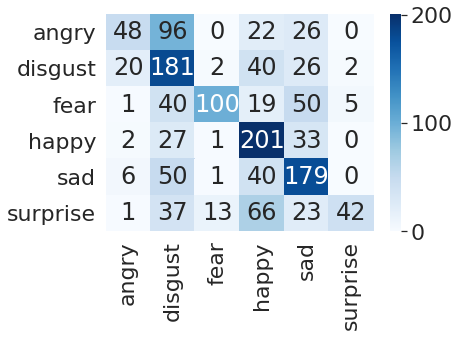

In [28]:
model = svm_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="svm")

              precision    recall  f1-score   support

           0    0.33673   0.34375   0.34021       192
           1    0.27152   0.30258   0.28621       271
           2    0.58564   0.49302   0.53535       215
           3    0.46691   0.48106   0.47388       264
           4    0.35458   0.32246   0.33776       276
           5    0.34343   0.37363   0.35789       182

    accuracy                        0.38429      1400
   macro avg    0.39314   0.38608   0.38855      1400
weighted avg    0.39127   0.38429   0.38675      1400

0.3842857142857143
[[ 66  45  10  27  26  18]
 [ 56  82  13  36  53  31]
 [ 17  32 106  12  23  25]
 [ 18  46   7 127  39  27]
 [ 26  65  32  35  89  29]
 [ 13  32  13  35  21  68]]
classwise-class accuracyangry: 0.34375
classwise-class accuracydisgust: 0.3025830258302583
classwise-class accuracyfear: 0.4930232558139535
classwise-class accuracyhappy: 0.4810606060606061
classwise-class accuracysad: 0.322463768115942
classwise-class accuracysurprise: 0.37

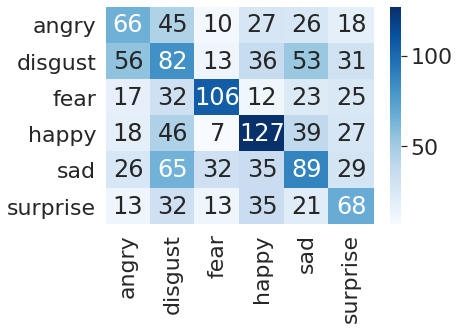

In [31]:
model = dt_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="dt1")

              precision    recall  f1-score   support

           0    0.52577   0.26562   0.35294       192
           1    0.37234   0.51661   0.43277       271
           2    0.77372   0.49302   0.60227       215
           3    0.44851   0.74242   0.55920       264
           4    0.51103   0.50362   0.50730       276
           5    0.64198   0.28571   0.39544       182

    accuracy                        0.48857      1400
   macro avg    0.54556   0.46784   0.47499      1400
weighted avg    0.53178   0.48857   0.48153      1400

0.48857142857142855
[[ 51  76   3  35  26   1]
 [ 27 140   6  65  30   3]
 [  5  34 106  21  30  19]
 [  5  37   1 196  24   1]
 [  8  52   6  66 139   5]
 [  1  37  15  54  23  52]]
classwise-class accuracyangry: 0.265625
classwise-class accuracydisgust: 0.5166051660516605
classwise-class accuracyfear: 0.4930232558139535
classwise-class accuracyhappy: 0.7424242424242424
classwise-class accuracysad: 0.5036231884057971
classwise-class accuracysurprise: 0

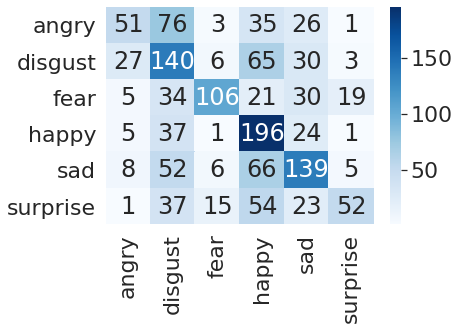

In [32]:
model = rf_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="rf1")

              precision    recall  f1-score   support

           0    0.32161   0.33333   0.32737       192
           1    0.35200   0.32472   0.33781       271
           2    0.54327   0.52558   0.53428       215
           3    0.49306   0.53788   0.51449       264
           4    0.42073   0.50000   0.45695       276
           5    0.29134   0.20330   0.23948       182

    accuracy                        0.41571      1400
   macro avg    0.40367   0.40414   0.40173      1400
weighted avg    0.40947   0.41571   0.41057      1400

0.4157142857142857
[[ 64  60   8  20  32   8]
 [ 59  88  14  44  53  13]
 [ 12  18 113  16  31  25]
 [ 22  21   7 142  45  27]
 [ 28  41  25  27 138  17]
 [ 14  22  41  39  29  37]]
classwise-class accuracyangry: 0.3333333333333333
classwise-class accuracydisgust: 0.3247232472324723
classwise-class accuracyfear: 0.5255813953488372
classwise-class accuracyhappy: 0.5378787878787878
classwise-class accuracysad: 0.5
classwise-class accuracysurprise: 0.20329

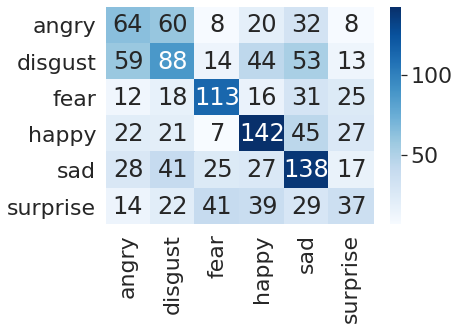

In [33]:
model = mnb_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="mnb1")

              precision    recall  f1-score   support

           0    0.31923   0.43229   0.36726       192
           1    0.36364   0.36900   0.36630       271
           2    0.56132   0.55349   0.55738       215
           3    0.47253   0.65152   0.54777       264
           4    0.50222   0.40942   0.45110       276
           5    0.48438   0.17033   0.25203       182

    accuracy                        0.44143      1400
   macro avg    0.45055   0.43101   0.42364      1400
weighted avg    0.45146   0.44143   0.43186      1400

0.44142857142857145
[[ 83  46  11  30  19   3]
 [ 68 100  20  44  29  10]
 [ 26  19 119  17  26   8]
 [ 21  35  10 172  21   5]
 [ 40  50  20  46 113   7]
 [ 22  25  32  55  17  31]]
classwise-class accuracyangry: 0.4322916666666667
classwise-class accuracydisgust: 0.36900369003690037
classwise-class accuracyfear: 0.5534883720930233
classwise-class accuracyhappy: 0.6515151515151515
classwise-class accuracysad: 0.40942028985507245
classwise-class accurac

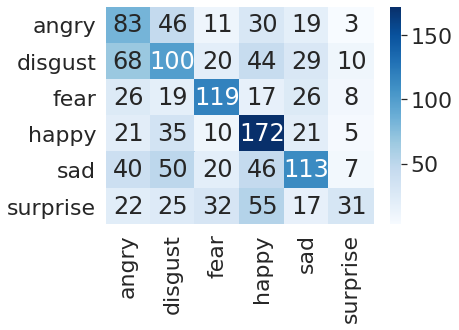

In [34]:
model = knn_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="knn1")

              precision    recall  f1-score   support

           0    0.79487   0.16146   0.26840       192
           1    0.33188   0.28044   0.30400       271
           2    0.80741   0.50698   0.62286       215
           3    0.28091   0.79167   0.41468       264
           4    0.43889   0.28623   0.34649       276
           5    0.72603   0.29121   0.41569       182

    accuracy                        0.39786      1400
   macro avg    0.56333   0.38633   0.39535      1400
weighted avg    0.53113   0.39786   0.39185      1400

0.39785714285714285
[[ 31  40   4 100  17   0]
 [  4  76   6 153  31   1]
 [  1  21 109  52  17  15]
 [  1  32   0 209  22   0]
 [  2  52   7 132  79   4]
 [  0   8   9  98  14  53]]
classwise-class accuracyangry: 0.16145833333333334
classwise-class accuracydisgust: 0.28044280442804426
classwise-class accuracyfear: 0.5069767441860465
classwise-class accuracyhappy: 0.7916666666666666
classwise-class accuracysad: 0.286231884057971
classwise-class accuracy

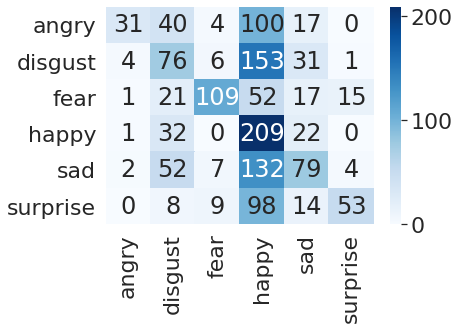

In [35]:
model = ada_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="ada1")

Tf-IDF with unigram+bigram

In [36]:
tf = TfidfVectorizer(ngram_range=(1,2), use_idf = True, tokenizer=lambda x: x.split(),  max_features=10000)
tf.fit_transform(X) ### Bit confusion arises here need to resolve
data = tf.transform(X)
data = pd.DataFrame(data.toarray())

split = 5600 #for Bemoc
train_data = data[0:5600]
train_data = train_data.to_numpy()
test_data =data[5600:]
test_data = test_data.to_numpy()
y_train = y[0:5600]
y_test = y[5600:]
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_train=pd.get_dummies(y_train).values
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_test=encoder.fit_transform(y_test)
y_test=pd.get_dummies(y_test).values
train_labels=np.argmax(y_train,axis=1)
test_labels=np.argmax(y_test,axis=1)

              precision    recall  f1-score   support

           0    0.64935   0.26042   0.37175       192
           1    0.42417   0.66052   0.51659       271
           2    0.82258   0.47442   0.60177       215
           3    0.51169   0.74621   0.60709       264
           4    0.52174   0.65217   0.57971       276
           5    0.87234   0.22527   0.35808       182

    accuracy                        0.53500      1400
   macro avg    0.63364   0.50317   0.50583      1400
weighted avg    0.61024   0.53500   0.51871      1400

0.535
[[ 50  98   0  21  23   0]
 [ 20 179   3  39  29   1]
 [  0  37 102  20  51   5]
 [  3  30   1 197  33   0]
 [  3  48   2  43 180   0]
 [  1  30  16  65  29  41]]
classwise-class accuracyangry: 0.2604166666666667
classwise-class accuracydisgust: 0.6605166051660517
classwise-class accuracyfear: 0.4744186046511628
classwise-class accuracyhappy: 0.7462121212121212
classwise-class accuracysad: 0.6521739130434783
classwise-class accuracysurprise: 0.225

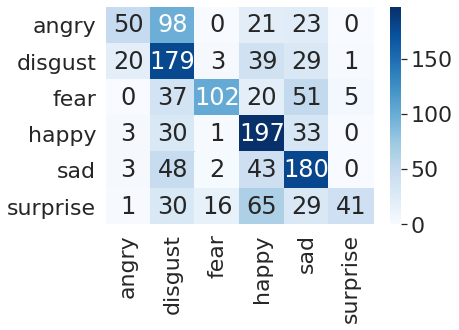

In [37]:
model = svm_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="svm2")

              precision    recall  f1-score   support

           0    0.31455   0.34896   0.33086       192
           1    0.29722   0.39483   0.33914       271
           2    0.51282   0.46512   0.48780       215
           3    0.45136   0.43939   0.44530       264
           4    0.41346   0.31159   0.35537       276
           5    0.37725   0.34615   0.36103       182

    accuracy                        0.38500      1400
   macro avg    0.39444   0.38434   0.38659      1400
weighted avg    0.39509   0.38500   0.38690      1400

0.385
[[ 67  62  14  16  20  13]
 [ 49 107  19  37  34  25]
 [ 17  38 100  16  18  26]
 [ 27  58  10 116  33  20]
 [ 35  63  31  41  86  20]
 [ 18  32  21  31  17  63]]
classwise-class accuracyangry: 0.3489583333333333
classwise-class accuracydisgust: 0.3948339483394834
classwise-class accuracyfear: 0.46511627906976744
classwise-class accuracyhappy: 0.4393939393939394
classwise-class accuracysad: 0.3115942028985507
classwise-class accuracysurprise: 0.34

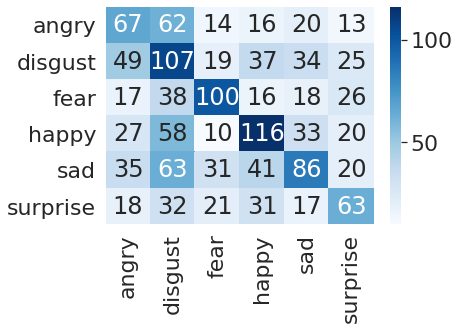

In [38]:
model = dt_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="dt2")

              precision    recall  f1-score   support

           0    0.47059   0.29167   0.36013       192
           1    0.37260   0.50185   0.42767       271
           2    0.76429   0.49767   0.60282       215
           3    0.47733   0.75758   0.58565       264
           4    0.54182   0.53986   0.54083       276
           5    0.67073   0.30220   0.41667       182

    accuracy                        0.50214      1400
   macro avg    0.54956   0.48180   0.48896      1400
weighted avg    0.53806   0.50214   0.49598      1400

0.5021428571428571
[[ 56  71   4  34  26   1]
 [ 36 136   8  57  31   3]
 [  5  29 107  26  31  17]
 [  6  33   2 200  21   2]
 [ 11  57   6  49 149   4]
 [  5  39  13  53  17  55]]
classwise-class accuracyangry: 0.2916666666666667
classwise-class accuracydisgust: 0.5018450184501845
classwise-class accuracyfear: 0.49767441860465117
classwise-class accuracyhappy: 0.7575757575757576
classwise-class accuracysad: 0.5398550724637681
classwise-class accuracys

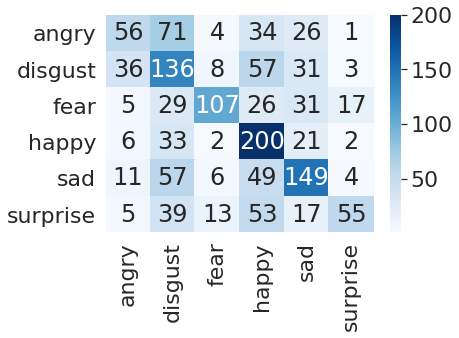

In [39]:
model = rf_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="rf2")

              precision    recall  f1-score   support

           0    0.32571   0.29688   0.31063       192
           1    0.32824   0.31734   0.32270       271
           2    0.56338   0.55814   0.56075       215
           3    0.52090   0.61364   0.56348       264
           4    0.42727   0.51087   0.46535       276
           5    0.41284   0.24725   0.30928       182

    accuracy                        0.43643      1400
   macro avg    0.42973   0.42402   0.42203      1400
weighted avg    0.43086   0.43643   0.42938      1400

0.43642857142857144
[[ 57  65  13  19  33   5]
 [ 63  86  17  43  46  16]
 [  4  17 120  15  37  22]
 [ 17  25   4 162  42  14]
 [ 23  41  23  41 141   7]
 [ 11  28  36  31  31  45]]
classwise-class accuracyangry: 0.296875
classwise-class accuracydisgust: 0.3173431734317343
classwise-class accuracyfear: 0.5581395348837209
classwise-class accuracyhappy: 0.6136363636363636
classwise-class accuracysad: 0.5108695652173914
classwise-class accuracysurprise: 0

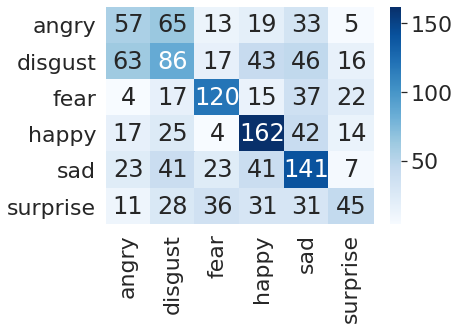

In [40]:
model = mnb_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="mnb2")

              precision    recall  f1-score   support

           0    0.32246   0.46354   0.38034       192
           1    0.37091   0.37638   0.37363       271
           2    0.55941   0.52558   0.54197       215
           3    0.48837   0.63636   0.55263       264
           4    0.46512   0.36232   0.40733       276
           5    0.45455   0.21978   0.29630       182

    accuracy                        0.43714      1400
   macro avg    0.44347   0.43066   0.42537      1400
weighted avg    0.44481   0.43714   0.43075      1400

0.43714285714285717
[[ 89  49  13  25  15   1]
 [ 73 102  17  37  29  13]
 [ 25  21 113  16  26  14]
 [ 27  26   6 168  25  12]
 [ 40  49  27  52 100   8]
 [ 22  28  26  46  20  40]]
classwise-class accuracyangry: 0.4635416666666667
classwise-class accuracydisgust: 0.3763837638376384
classwise-class accuracyfear: 0.5255813953488372
classwise-class accuracyhappy: 0.6363636363636364
classwise-class accuracysad: 0.36231884057971014
classwise-class accuracy

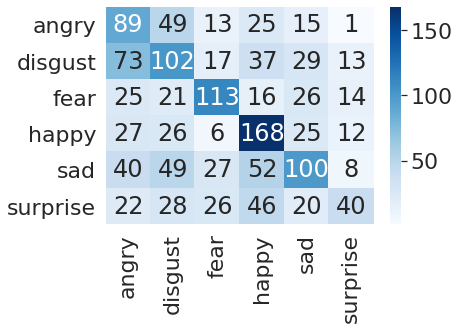

In [41]:
model = knn_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="knn2")

              precision    recall  f1-score   support

           0    0.80488   0.17188   0.28326       192
           1    0.34630   0.32841   0.33712       271
           2    0.78169   0.51628   0.62185       215
           3    0.27801   0.76136   0.40729       264
           4    0.46154   0.23913   0.31504       276
           5    0.58511   0.30220   0.39855       182

    accuracy                        0.39643      1400
   macro avg    0.54292   0.38654   0.39385      1400
weighted avg    0.51694   0.39643   0.39033      1400

0.3964285714285714
[[ 33  45   5  97  11   1]
 [  4  89   7 145  21   5]
 [  1  21 111  48  14  20]
 [  1  34   2 201  21   5]
 [  2  56   7 137  66   8]
 [  0  12  10  95  10  55]]
classwise-class accuracyangry: 0.171875
classwise-class accuracydisgust: 0.3284132841328413
classwise-class accuracyfear: 0.5162790697674419
classwise-class accuracyhappy: 0.7613636363636364
classwise-class accuracysad: 0.2391304347826087
classwise-class accuracysurprise: 0.

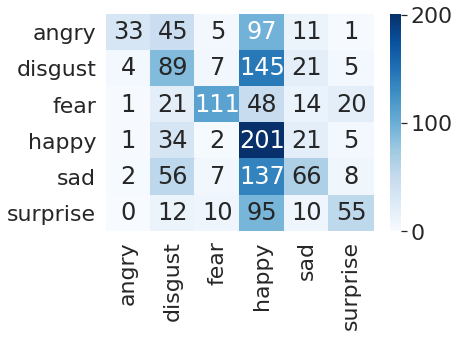

In [42]:
model = ada_model
model.fit(train_data, train_labels)
evaluation_ml(model,test_data,test_labels,name="ada2")

Oversampling and undersampling

In [14]:

tf = TfidfVectorizer(ngram_range=(1,1), use_idf = True, tokenizer=lambda x: x.split(),  max_features=10000)
tf.fit_transform(X) ### Bit confusion arises here need to resolve
data = tf.transform(X)
data = pd.DataFrame(data.toarray())
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

split = 5600 #for Bemoc
train_data = data[0:5600]
train_data = train_data.to_numpy()
test_data =data[5600:]
test_data = test_data.to_numpy()
y_train = y[0:5600]
y_test = y[5600:]

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_train=pd.get_dummies(y_train).values
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_test=encoder.fit_transform(y_test)
y_test=pd.get_dummies(y_test).values
train_labels=np.argmax(y_train,axis=1)
test_labels=np.argmax(y_test,axis=1)


oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(train_data, train_labels)

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(train_data, train_labels)

# Class distribution after balancing
print("\nClass distribution after oversampling:")
print(pd.Series(y_train_over).value_counts())

print("\nClass distribution after undersampling:")
print(pd.Series(y_train_under).value_counts())


Class distribution after oversampling:
3    1260
2    1260
5    1260
1    1260
4    1260
0    1260
dtype: int64

Class distribution after undersampling:
5    597
3    597
1    597
4    597
2    597
0    597
dtype: int64


              precision    recall  f1-score   support

           0    0.56637   0.33333   0.41967       192
           1    0.44246   0.63838   0.52266       271
           2    0.83582   0.52093   0.64183       215
           3    0.54775   0.73864   0.62903       264
           4    0.54354   0.65580   0.59442       276
           5    0.73973   0.29670   0.42353       182

    accuracy                        0.55643      1400
   macro avg    0.61261   0.53063   0.53852      1400
weighted avg    0.59829   0.55643   0.54816      1400

0.5564285714285714
[[ 64  79   0  21  27   1]
 [ 31 173   3  34  26   4]
 [  2  32 112  16  43  10]
 [  4  30   1 195  32   2]
 [ 10  46   6  31 181   2]
 [  2  31  12  59  24  54]]
classwise-class accuracyangry: 0.3333333333333333
classwise-class accuracydisgust: 0.6383763837638377
classwise-class accuracyfear: 0.5209302325581395
classwise-class accuracyhappy: 0.7386363636363636
classwise-class accuracysad: 0.6557971014492754
classwise-class accuracysu

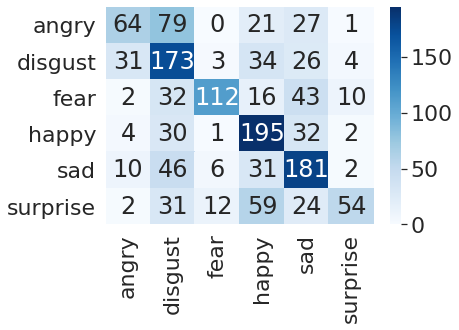

In [20]:
model = svm_model
model.fit(X_train_over, y_train_over)
evaluation_ml(model,test_data,test_labels,name="svm_over")

              precision    recall  f1-score   support

           0    0.40278   0.45312   0.42647       192
           1    0.42812   0.50554   0.46362       271
           2    0.82734   0.53488   0.64972       215
           3    0.69124   0.56818   0.62370       264
           4    0.55254   0.59058   0.57093       276
           5    0.49296   0.57692   0.53165       182

    accuracy                        0.54071      1400
   macro avg    0.56583   0.53820   0.54435      1400
weighted avg    0.56853   0.54071   0.54729      1400

0.5407142857142857
[[ 87  65   0   8  21  11]
 [ 62 137   4  12  31  25]
 [  8  23 115   9  26  34]
 [ 18  31   1 150  40  24]
 [ 33  41   8  17 163  14]
 [  8  23  11  21  14 105]]
classwise-class accuracyangry: 0.453125
classwise-class accuracydisgust: 0.5055350553505535
classwise-class accuracyfear: 0.5348837209302325
classwise-class accuracyhappy: 0.5681818181818182
classwise-class accuracysad: 0.5905797101449275
classwise-class accuracysurprise: 0.

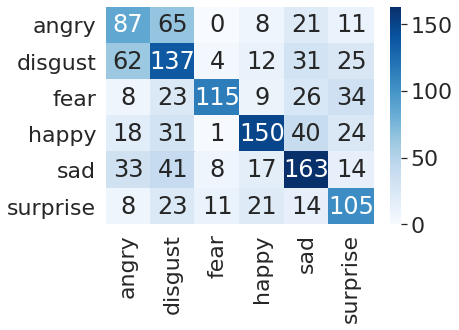

In [21]:
model = svm_model
model.fit(X_train_under, y_train_under)
evaluation_ml(model,test_data,test_labels,name="svm_under")